In [140]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [141]:
def set_seed(seed=55):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 55
set_seed(SEED)


In [142]:
TRAIN_DIR = "train"
TEST_DIR  = "test"

TRAIN_SIG_DIR = os.path.join("train/Inertial Signals")
TEST_SIG_DIR  = os.path.join("test/Inertial Signals")


In [143]:
def load_signal_file(path: str) -> np.ndarray:
    # Each file: (num_windows, 128) whitespace-separated
    return np.loadtxt(path)


In [144]:
SIGNALS = [
    "body_acc_x", "body_acc_y", "body_acc_z",
    "body_gyro_x", "body_gyro_y", "body_gyro_z",
    "total_acc_x", "total_acc_y", "total_acc_z"
]

def load_split(split_dir: str, sig_dir: str, split_name: str):
    xs = []
    for s in SIGNALS:
        fname = f"{s}_{split_name}.txt"
        path = os.path.join(sig_dir, fname)
        arr = load_signal_file(path)
        xs.append(arr[..., None])  
    X = np.concatenate(xs, axis=2)   

    y = np.loadtxt(os.path.join(split_dir, f"y_{split_name}.txt")).astype(int)  # 1..6
    subj = np.loadtxt(os.path.join(split_dir, f"subject_{split_name}.txt")).astype(int)

    y = y - 1
    return X, y, subj

X_train_full, y_train_full, subj_train_full = load_split(TRAIN_DIR, TRAIN_SIG_DIR, "train")
X_test, y_test, subj_test = load_split(TEST_DIR, TEST_SIG_DIR, "test")

X_train_full.shape, y_train_full.shape, subj_train_full.shape, X_test.shape


((7352, 128, 9), (7352,), (7352,), (2947, 128, 9))

In [145]:
print("Train X:", X_train_full.shape, "y:", y_train_full.shape)
print("Test  X:", X_test.shape,       "y:", y_test.shape)

print("NaNs train:", np.isnan(X_train_full).sum(), "Infs train:", np.isinf(X_train_full).sum())
print("NaNs test :", np.isnan(X_test).sum(),       "Infs test :", np.isinf(X_test).sum())

train_counts = pd.Series(y_train_full).value_counts().sort_index()
test_counts  = pd.Series(y_test).value_counts().sort_index()

display(pd.DataFrame({"train": train_counts, "test": test_counts}).fillna(0).astype(int))


Train X: (7352, 128, 9) y: (7352,)
Test  X: (2947, 128, 9) y: (2947,)
NaNs train: 0 Infs train: 0
NaNs test : 0 Infs test : 0


,train,test
0,1226,496
1,1073,471
2,986,420
3,1286,491
4,1374,532
5,1407,537


In [146]:
def subject_disjoint_train_val_split(X, y, subj, val_frac=0.2, seed=42):
    rng = np.random.default_rng(seed)
    unique_subj = np.unique(subj)
    rng.shuffle(unique_subj)

    n_val = int(len(unique_subj) * val_frac)
    val_subj = set(unique_subj[:n_val])
    train_subj = set(unique_subj[n_val:])

    train_mask = np.array([s in train_subj for s in subj])
    val_mask   = np.array([s in val_subj   for s in subj])

    return (X[train_mask], y[train_mask], subj[train_mask]), (X[val_mask], y[val_mask], subj[val_mask])

(X_train, y_train, subj_train), (X_val, y_val, subj_val) = subject_disjoint_train_val_split(
    X_train_full, y_train_full, subj_train_full, val_frac=0.2, seed=SEED
)

print("Train windows:", X_train.shape[0], "Val windows:", X_val.shape[0])
print("Train subjects:", len(set(subj_train.tolist())), "Val subjects:", len(set(subj_val.tolist())))
print("Train/Val subject overlap:", len(set(subj_train.tolist()) & set(subj_val.tolist())))


Train windows: 5931 Val windows: 1421
Train subjects: 17 Val subjects: 4
Train/Val subject overlap: 0


In [147]:
majority_class = pd.Series(y_train).value_counts().idxmax()
y_pred_val = np.full_like(y_val, majority_class)

acc = accuracy_score(y_val, y_pred_val)
mf1 = f1_score(y_val, y_pred_val, average="macro")

print("Majority baseline on VAL")
print("Accuracy:", acc)
print("F1:", mf1)


Majority baseline on VAL
Accuracy: 0.19141449683321604
F1: 0.05355384918291003


In [148]:
class HARFlatDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx].reshape(-1)
        return x, self.y[idx]

batch_size = 128

train_loader = DataLoader(HARFlatDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(HARFlatDataset(X_val, y_val),     batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(HARFlatDataset(X_test, y_test),   batch_size=batch_size, shuffle=False)

input_dim = X_train.shape[1] * X_train.shape[2]
num_classes = len(np.unique(y_train_full))
input_dim, num_classes


(1152, 6)

In [149]:
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)

        )

    def forward(self, x):
        return self.net(x)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = MLP(input_dim, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [150]:
def run_epoch(model, loader, train=True):
    model.train() if train else model.eval()

    total_loss = 0.0
    all_preds, all_true = [], []

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)

            if train:
                loss.backward()
                optimizer.step()

        total_loss += loss.item() * xb.size(0)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.detach().cpu().numpy())
        all_true.append(yb.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_true = np.concatenate(all_true)

    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_true, all_preds)
    mf1 = f1_score(all_true, all_preds, average="macro")
    return avg_loss, acc, mf1, all_true, all_preds


In [151]:
epochs = 15

history = []
for ep in range(1, epochs + 1):
    tr_loss, tr_acc, tr_mf1, _, _ = run_epoch(model, train_loader, train=True)
    va_loss, va_acc, va_mf1, y_true, y_pred = run_epoch(model, val_loader, train=False)

    history.append([ep, tr_loss, tr_acc, tr_mf1, va_loss, va_acc, va_mf1])
    print(f"Epoch {ep:02d} train loss {tr_loss:.4f} acc {tr_acc:.4f} mf1 {tr_mf1:.4f} val loss {va_loss:.4f} acc {va_acc:.4f} mf1 {va_mf1:.4f}")

history_df = pd.DataFrame(history, columns=["epoch","tr_loss","tr_acc","tr_mf1","va_loss","va_acc","va_mf1"])
history_df.tail()


Epoch 01 train loss 1.0481 acc 0.5950 mf1 0.5734 val loss 1.0247 acc 0.7488 mf1 0.7366
Epoch 02 train loss 0.3678 acc 0.8759 mf1 0.8703 val loss 0.6754 acc 0.8220 mf1 0.8244
Epoch 03 train loss 0.2065 acc 0.9243 mf1 0.9239 val loss 0.6298 acc 0.8353 mf1 0.8370
Epoch 04 train loss 0.1402 acc 0.9462 mf1 0.9478 val loss 0.6742 acc 0.8276 mf1 0.8288
Epoch 05 train loss 0.1222 acc 0.9548 mf1 0.9569 val loss 0.5537 acc 0.8276 mf1 0.8313
Epoch 06 train loss 0.1073 acc 0.9558 mf1 0.9584 val loss 0.6064 acc 0.8543 mf1 0.8574
Epoch 07 train loss 0.0940 acc 0.9617 mf1 0.9644 val loss 0.6769 acc 0.8515 mf1 0.8549
Epoch 08 train loss 0.0854 acc 0.9648 mf1 0.9673 val loss 0.7005 acc 0.8473 mf1 0.8494
Epoch 09 train loss 0.0819 acc 0.9654 mf1 0.9680 val loss 0.7100 acc 0.8311 mf1 0.8361
Epoch 10 train loss 0.0831 acc 0.9644 mf1 0.9670 val loss 0.8052 acc 0.8473 mf1 0.8494
Epoch 11 train loss 0.0764 acc 0.9673 mf1 0.9697 val loss 0.8698 acc 0.8255 mf1 0.8302
Epoch 12 train loss 0.0707 acc 0.9683 mf1 0

,epoch,tr_loss,tr_acc,tr_mf1,va_loss,va_acc,va_mf1
10,11,0.076424,0.967291,0.969685,0.869776,0.825475,0.830156
11,12,0.070710,0.968302,0.970584,0.918676,0.831105,0.835294
12,13,0.066293,0.971337,0.973419,0.934943,0.838846,0.842465
13,14,0.065755,0.972517,0.974521,0.982235,0.846587,0.849462
14,15,0.064271,0.972686,0.974691,1.263197,0.846587,0.848422


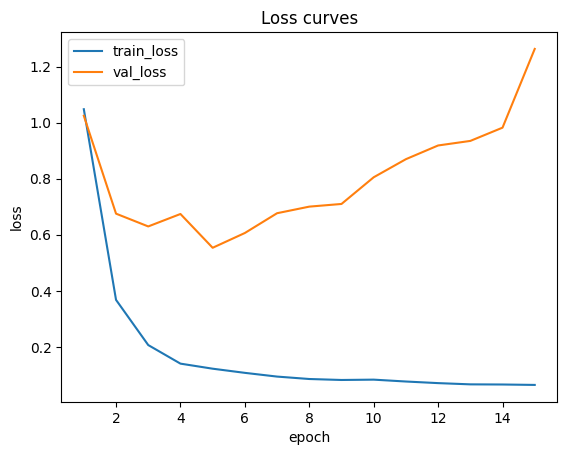

In [152]:
plt.figure()
plt.plot(history_df["epoch"], history_df["tr_loss"], label="train_loss")
plt.plot(history_df["epoch"], history_df["va_loss"], label="val_loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.title("Loss curves")
plt.show()


In [153]:
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

print("\nPer-class metrics:")
print(classification_report(y_true, y_pred, digits=4))


Confusion Matrix:
 [[165   2  19  38   4   0]
 [  3 166  35   5   0   0]
 [  3   0 181   3   2   0]
 [  0   0   0 226  25   0]
 [  0   0   0  79 193   0]
 [  0   0   0   0   0 272]]

Per-class metrics:
              precision    recall  f1-score   support

           0     0.9649    0.7237    0.8271       228
           1     0.9881    0.7943    0.8806       209
           2     0.7702    0.9577    0.8538       189
           3     0.6439    0.9004    0.7508       251
           4     0.8616    0.7096    0.7782       272
           5     1.0000    1.0000    1.0000       272

    accuracy                         0.8466      1421
   macro avg     0.8715    0.8476    0.8484      1421
weighted avg     0.8727    0.8466    0.8488      1421



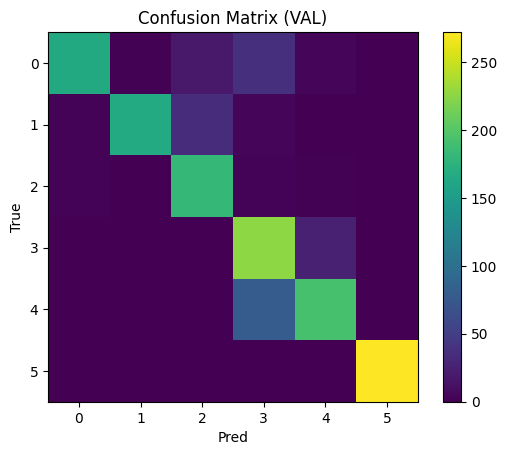

In [154]:
plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix (VAL)")
plt.xlabel("Pred"); plt.ylabel("True")
plt.colorbar()
plt.show()


# Week 2

In [155]:
import random
import numpy as np
import torch
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

SEED = 55

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

EXPERIMENT_LOG = []

def plot_history(history_df, title):

    # Loss
    plt.figure()
    plt.plot(history_df["epoch"], history_df["train_loss"], label="train")
    plt.plot(history_df["epoch"], history_df["val_loss"], label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title} - Loss")
    plt.legend()
    plt.show()

    # Macro-F1
    plt.figure()
    plt.plot(history_df["epoch"], history_df["train_mf1"], label="train")
    plt.plot(history_df["epoch"], history_df["val_mf1"], label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Macro-F1")
    plt.title(f"{title} - Macro-F1")
    plt.legend()
    plt.show()

In [156]:
def train_model(model, optimizer, epochs, use_early_stopping=False, patience=5,
                use_grad_clip=False, max_norm=1.0):

    best_val_mf1 = -1
    best_epoch = 0
    patience_counter = 0
    history = []

    for ep in range(1, epochs+1):

        model.train()
        train_loss = 0
        all_preds, all_true = [], []

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()

            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()

            if use_grad_clip:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

            optimizer.step()

            train_loss += loss.item() * xb.size(0)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_true.append(yb.cpu().numpy())

        train_loss /= len(train_loader.dataset)
        train_mf1 = f1_score(np.concatenate(all_true),
                             np.concatenate(all_preds),
                             average="macro")

        model.eval()
        val_loss = 0
        all_preds, all_true = [], []

        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)

                val_loss += loss.item() * xb.size(0)
                preds = torch.argmax(logits, dim=1)
                all_preds.append(preds.cpu().numpy())
                all_true.append(yb.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_mf1 = f1_score(np.concatenate(all_true),
                           np.concatenate(all_preds),
                           average="macro")

        history.append([ep, train_loss, val_loss, train_mf1, val_mf1])

        print(f"Epoch {ep:02d} | "
              f"Train Loss {train_loss:.4f} | Val Loss {val_loss:.4f} | "
              f"Train F1 {train_mf1:.4f} | Val F1 {val_mf1:.4f}")

        if use_early_stopping:
            if val_mf1 > best_val_mf1:
                best_val_mf1 = val_mf1
                best_epoch = ep
                best_weights = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered.")
                    model.load_state_dict(best_weights)
                    break

    return pd.DataFrame(history,
                        columns=["epoch","train_loss","val_loss",
                                 "train_mf1","val_mf1"])

In [157]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        return self.net(x)

model = SimpleMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

history_baseline = train_model(model, optimizer, epochs=20)

best_val = history_baseline["val_mf1"].max()

EXPERIMENT_LOG.append({
    "name": "baseline",
    "seed": SEED,
    "best_val_mf1": best_val,
    "note": "Baseline model"
})

Epoch 01 | Train Loss 0.9500 | Val Loss 0.8861 | Train F1 0.6388 | Val F1 0.7504
Epoch 02 | Train Loss 0.3040 | Val Loss 0.7227 | Train F1 0.8933 | Val F1 0.8329
Epoch 03 | Train Loss 0.1704 | Val Loss 0.7226 | Train F1 0.9401 | Val F1 0.8445
Epoch 04 | Train Loss 0.1266 | Val Loss 0.7534 | Train F1 0.9568 | Val F1 0.8498
Epoch 05 | Train Loss 0.1069 | Val Loss 0.7551 | Train F1 0.9631 | Val F1 0.8243
Epoch 06 | Train Loss 0.0967 | Val Loss 0.8282 | Train F1 0.9648 | Val F1 0.8404
Epoch 07 | Train Loss 0.0899 | Val Loss 0.7692 | Train F1 0.9667 | Val F1 0.8361
Epoch 08 | Train Loss 0.0864 | Val Loss 0.7397 | Train F1 0.9648 | Val F1 0.8386
Epoch 09 | Train Loss 0.0798 | Val Loss 0.7116 | Train F1 0.9673 | Val F1 0.8335
Epoch 10 | Train Loss 0.0767 | Val Loss 0.7068 | Train F1 0.9692 | Val F1 0.8381
Epoch 11 | Train Loss 0.0801 | Val Loss 0.7579 | Train F1 0.9689 | Val F1 0.8507
Epoch 12 | Train Loss 0.0767 | Val Loss 0.6821 | Train F1 0.9695 | Val F1 0.8379
Epoch 13 | Train Loss 0.0702

In [158]:
class BigMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model = BigMLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

history_overfit = train_model(model, optimizer, epochs=80)

best_val_overfit = history_overfit["val_mf1"].max()

EXPERIMENT_LOG.append({
    "name": "overfit_big_model",
    "seed": SEED,
    "best_val_mf1": best_val_overfit,
    "note": "Oversized model without regularization"
})

Epoch 01 | Train Loss 0.8538 | Val Loss 0.7676 | Train F1 0.6389 | Val F1 0.8105
Epoch 02 | Train Loss 0.2769 | Val Loss 0.7389 | Train F1 0.8962 | Val F1 0.8106
Epoch 03 | Train Loss 0.1608 | Val Loss 0.8955 | Train F1 0.9427 | Val F1 0.8364
Epoch 04 | Train Loss 0.1160 | Val Loss 1.0546 | Train F1 0.9523 | Val F1 0.8108
Epoch 05 | Train Loss 0.1053 | Val Loss 0.8808 | Train F1 0.9558 | Val F1 0.8359
Epoch 06 | Train Loss 0.0969 | Val Loss 0.9193 | Train F1 0.9623 | Val F1 0.8217
Epoch 07 | Train Loss 0.0828 | Val Loss 1.0157 | Train F1 0.9666 | Val F1 0.8261
Epoch 08 | Train Loss 0.0897 | Val Loss 1.1152 | Train F1 0.9619 | Val F1 0.8334
Epoch 09 | Train Loss 0.0870 | Val Loss 1.2024 | Train F1 0.9625 | Val F1 0.8308
Epoch 10 | Train Loss 0.0840 | Val Loss 1.1969 | Train F1 0.9653 | Val F1 0.8332
Epoch 11 | Train Loss 0.1517 | Val Loss 0.8743 | Train F1 0.9536 | Val F1 0.8386
Epoch 12 | Train Loss 0.1010 | Val Loss 0.7767 | Train F1 0.9607 | Val F1 0.8422
Epoch 13 | Train Loss 0.0822

In [159]:
class BigMLP_Dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model = BigMLP_Dropout().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

history_fixed = train_model(model, optimizer,
                            epochs=80,
                            use_early_stopping=True,
                            patience=8)

best_val_fixed = history_fixed["val_mf1"].max()

EXPERIMENT_LOG.append({
    "name": "overfit_fixed_dropout_earlystop",
    "seed": SEED,
    "best_val_mf1": best_val_fixed,
    "note": "Fixed using dropout + early stopping"
})

Epoch 01 | Train Loss 0.9799 | Val Loss 0.9778 | Train F1 0.5586 | Val F1 0.7352
Epoch 02 | Train Loss 0.4074 | Val Loss 0.8893 | Train F1 0.8337 | Val F1 0.7791
Epoch 03 | Train Loss 0.2077 | Val Loss 1.0530 | Train F1 0.9215 | Val F1 0.8366
Epoch 04 | Train Loss 0.1563 | Val Loss 1.1321 | Train F1 0.9410 | Val F1 0.8302
Epoch 05 | Train Loss 0.1421 | Val Loss 1.1462 | Train F1 0.9452 | Val F1 0.8555
Epoch 06 | Train Loss 0.1169 | Val Loss 1.3066 | Train F1 0.9585 | Val F1 0.8387
Epoch 07 | Train Loss 0.1223 | Val Loss 1.6988 | Train F1 0.9536 | Val F1 0.8354
Epoch 08 | Train Loss 0.1127 | Val Loss 1.5067 | Train F1 0.9562 | Val F1 0.8277
Epoch 09 | Train Loss 0.1151 | Val Loss 1.1243 | Train F1 0.9546 | Val F1 0.8202
Epoch 10 | Train Loss 0.1092 | Val Loss 1.4264 | Train F1 0.9588 | Val F1 0.8373
Epoch 11 | Train Loss 0.0983 | Val Loss 2.0265 | Train F1 0.9607 | Val F1 0.8372
Epoch 12 | Train Loss 0.0941 | Val Loss 2.0265 | Train F1 0.9617 | Val F1 0.8345
Epoch 13 | Train Loss 0.0942

In [160]:
model = SimpleMLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)

history_unstable = train_model(model, optimizer, epochs=30)

best_val_unstable = history_unstable["val_mf1"].max()

EXPERIMENT_LOG.append({
    "name": "unstable_high_lr",
    "seed": SEED,
    "best_val_mf1": best_val_unstable,
    "note": "High LR causing instability"
})

Epoch 01 | Train Loss 154.2463 | Val Loss 435.0711 | Train F1 0.3504 | Val F1 0.2206
Epoch 02 | Train Loss 14.0744 | Val Loss 72.2314 | Train F1 0.3632 | Val F1 0.2560
Epoch 03 | Train Loss 9.2104 | Val Loss 42.2603 | Train F1 0.3875 | Val F1 0.2589
Epoch 04 | Train Loss 15.5284 | Val Loss 2.2823 | Train F1 0.4106 | Val F1 0.3097
Epoch 05 | Train Loss 13.0916 | Val Loss 4.5693 | Train F1 0.3961 | Val F1 0.2855
Epoch 06 | Train Loss 3.2579 | Val Loss 254.9604 | Train F1 0.4090 | Val F1 0.3105
Epoch 07 | Train Loss 1.8888 | Val Loss 322.1777 | Train F1 0.3998 | Val F1 0.3232
Epoch 08 | Train Loss 1.6516 | Val Loss 231.3073 | Train F1 0.3850 | Val F1 0.3180
Epoch 09 | Train Loss 1.2204 | Val Loss 130.3795 | Train F1 0.3930 | Val F1 0.3175
Epoch 10 | Train Loss 1.2092 | Val Loss 143.0852 | Train F1 0.3983 | Val F1 0.3174
Epoch 11 | Train Loss 1.1697 | Val Loss 143.7709 | Train F1 0.3915 | Val F1 0.3174
Epoch 12 | Train Loss 1.1721 | Val Loss 144.0658 | Train F1 0.3974 | Val F1 0.3174
Epoch

In [161]:
class NormalizedMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(input_dim),
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model = NormalizedMLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

history_fixed_unstable = train_model(model, optimizer,
                                      epochs=30,
                                      use_grad_clip=True,
                                      max_norm=1.0)

best_val_fixed_unstable = history_fixed_unstable["val_mf1"].max()

EXPERIMENT_LOG.append({
    "name": "unstable_fixed_clip_norm",
    "seed": SEED,
    "best_val_mf1": best_val_fixed_unstable,
    "note": "Fixed using gradient clipping + LayerNorm"
})

Epoch 01 | Train Loss 0.9546 | Val Loss 1.1935 | Train F1 0.5464 | Val F1 0.4660
Epoch 02 | Train Loss 0.4341 | Val Loss 0.8982 | Train F1 0.8213 | Val F1 0.7730
Epoch 03 | Train Loss 0.2162 | Val Loss 0.9372 | Train F1 0.9126 | Val F1 0.7925
Epoch 04 | Train Loss 0.1387 | Val Loss 1.0062 | Train F1 0.9486 | Val F1 0.8007
Epoch 05 | Train Loss 0.1107 | Val Loss 1.1004 | Train F1 0.9570 | Val F1 0.8259
Epoch 06 | Train Loss 0.1076 | Val Loss 1.1788 | Train F1 0.9600 | Val F1 0.8253
Epoch 07 | Train Loss 0.0878 | Val Loss 1.2019 | Train F1 0.9656 | Val F1 0.8096
Epoch 08 | Train Loss 0.1383 | Val Loss 1.1230 | Train F1 0.9569 | Val F1 0.8275
Epoch 09 | Train Loss 0.0773 | Val Loss 1.6298 | Train F1 0.9680 | Val F1 0.8217
Epoch 10 | Train Loss 0.0848 | Val Loss 1.5640 | Train F1 0.9654 | Val F1 0.8484
Epoch 11 | Train Loss 0.0882 | Val Loss 1.5680 | Train F1 0.9634 | Val F1 0.8428
Epoch 12 | Train Loss 0.0737 | Val Loss 2.0174 | Train F1 0.9689 | Val F1 0.8237
Epoch 13 | Train Loss 0.0819

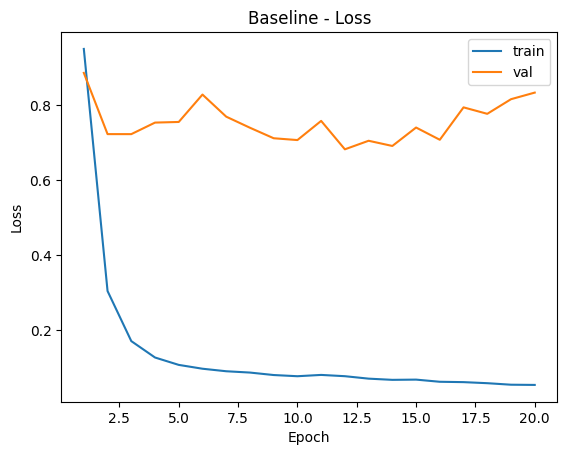

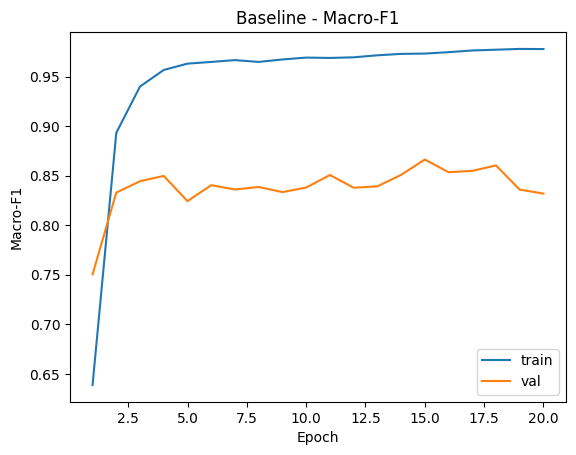

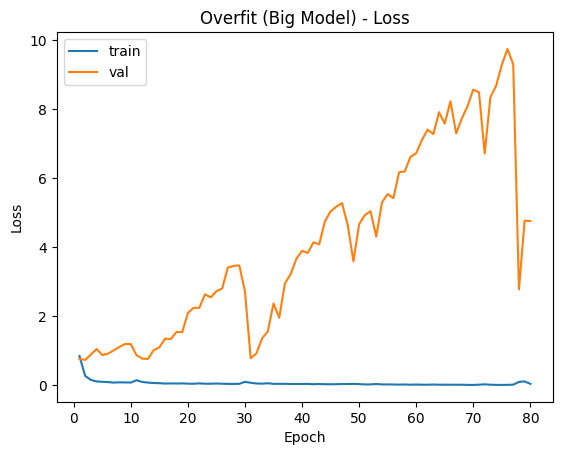

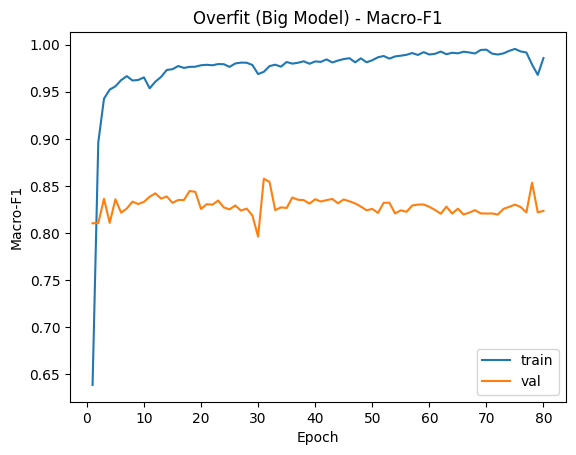

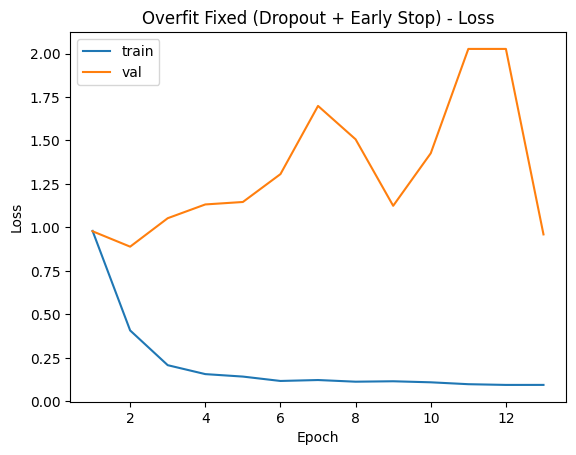

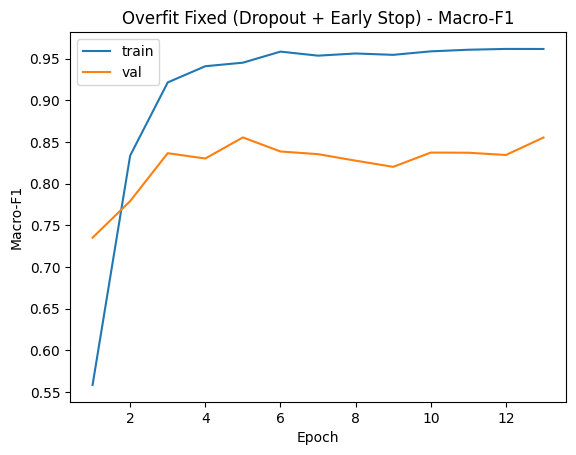

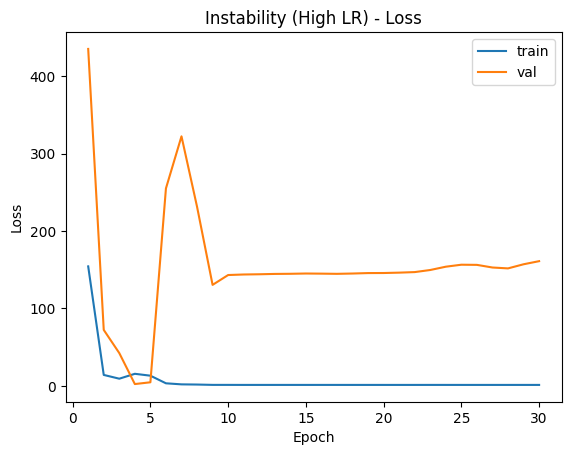

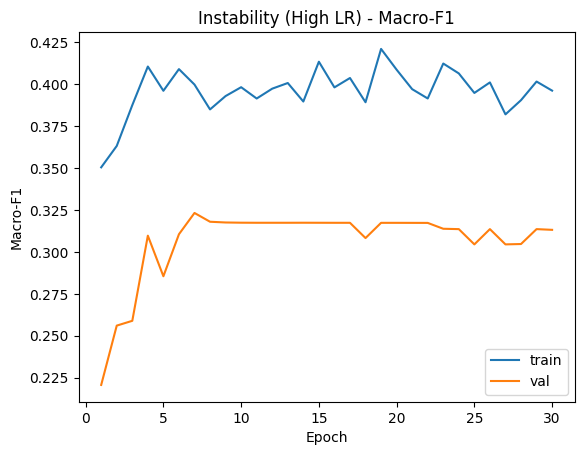

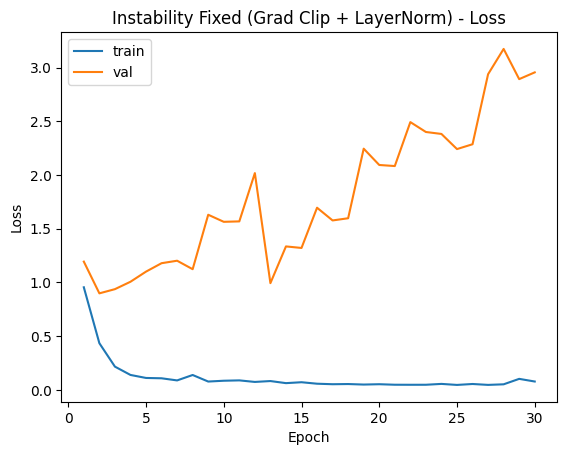

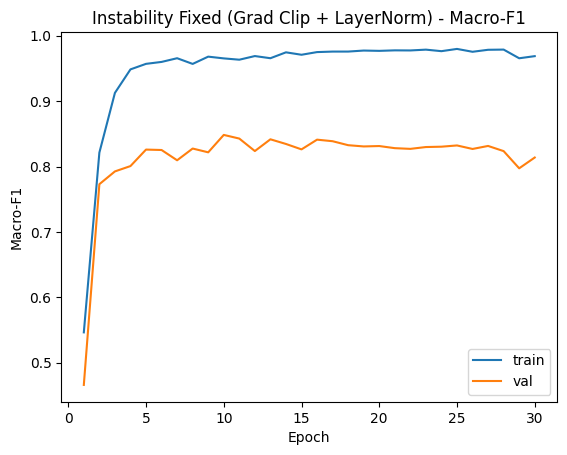

In [162]:
plot_history(history_baseline, "Baseline")
plot_history(history_overfit, "Overfit (Big Model)")
plot_history(history_fixed, "Overfit Fixed (Dropout + Early Stop)")
plot_history(history_unstable, "Instability (High LR)")
plot_history(history_fixed_unstable, "Instability Fixed (Grad Clip + LayerNorm)")

In [163]:
pd.DataFrame(EXPERIMENT_LOG)

,name,seed,best_val_mf1,note
0,baseline,55,0.866338,Baseline model
1,overfit_big_model,55,0.857665,Oversized model without regularization
2,overfit_fixed_dropout_earlystop,55,0.855523,Fixed using dropout + early stopping
3,unstable_high_lr,55,0.323226,High LR causing instability
4,unstable_fixed_clip_norm,55,0.848361,Fixed using gradient clipping + LayerNorm
